In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase import Atoms
from ase.build import bulk
from ase.build import make_supercell
from numpy import poly1d
from numpy import polyfit
import time
import sys
sys.path.append('../code')
from Generate_Descriptors import get_dscribe_descriptors

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

In [4]:
class discrete_dscribe_variable():
    def __init__(self, variable_name, default_value, value_array, profiler_to_soap_map = lambda x: x):
        self.name = variable_name
        self.profiler_to_soap_map = profiler_to_soap_map 
        self.default_profiler_value = default_value
        self.default_soap_value = self.profiler_to_soap_map(self.default_profiler_value)
        self.profiler_value_array = value_array
        self.soap_value_array = [self.profiler_to_soap_map(profiler_value) for profiler_value in self.profiler_value_array]
        self.refresh()
        self.times = []
        
    def refresh(self):
        self.current_profiler_value = self.default_profiler_value
        self.current_soap_value = self.profiler_to_soap_map(self.current_profiler_value)
        
    def plot(self, title="", max_time = 0):
        self.fig, self.ax = plt.subplots()
        self.ax.plot(self.soap_value_array, self.times, "o", c='k',zorder=1)
        self.best_fit_coefficients = polyfit(self.soap_value_array, self.times, 2)
        self.best_fit_equation = "t =  {:.1f} x^2 \n+ {:.0f} x \n+ {:.0f}".format(*self.best_fit_coefficients)
        self.equation_y_position = max(min(self.times[len(self.times)//2]/max_time + .2, .9), .2)
        self.polynomial_fit = poly1d(self.best_fit_coefficients)
        self.ax.plot(self.soap_value_array, self.polynomial_fit(self.soap_value_array), '--', c='r', zorder=0)
        self.ax.text(0.5, self.equation_y_position, self.best_fit_equation, horizontalalignment='center', verticalalignment='center', transform=self.ax.transAxes)
        self.ax.set_title(title)
        self.ax.set_xlabel(self.name)
        self.ax.set_ylabel("Time per structure (ms)")
        self.ax.set_ylim(0,1.1*max_time)
        
        
class dscribe_profiler():
    def __init__(self, structure_list, name=""):
        if isinstance(structure_list, Atoms):
            self.structures = [structure_list]
        elif isinstance(structure_list, (list,np.ndarray)):
            self.structures = structure_list
        self.n_structures = len(self.structures)
        self.n_atoms = len(self.structures[-1].positions)
        self.species = np.unique(self.structures[0].get_chemical_symbols())
        self.unique_elements_count = len(self.species)
        self.name = name if name else self.structures[0].get_chemical_formula()
        self.max_time = 0
        
        self.variables = {}
        self.lmaxs = self.add_dscribe_variable("lmax", 9, range(0,10))
        self.nmaxs = self.add_dscribe_variable("nmax", 11, range(1,12))
        self.element_options = ["C", "H", "O", "N", "He", "Li", "Be", "B", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar"]
        #self.element_counts = self.add_dscribe_variable("element_count", self.unique_elements_count, range(self.unique_elements_count, 10))
        self.element_counts = self.add_dscribe_variable("element_count", 9, range(self.unique_elements_count, 10))
        # it turns out you need rcuts to be floats not ints or a numerical issue appears (hence the 1.0)
        self.rcuts = self.add_dscribe_variable("rcut", 14, np.arange(2, 15, 1.0)) 
        
        self.format="default"
    
    def vary_by_structure_mode(self):
        self.format="vary_by_structure"
        self.structure_ids = self.add_dscribe_variable("atom_count", -1, range(len(self.structures)), lambda x: len(self.structures[x].positions))
        self.n_structures = 1
        self.max_time = 0
        
    def get_structures(self):
        if self.format == "default":
            return self.structures
        elif self.format == "vary_by_structure":
            return self.structures[self.structure_ids.current_profiler_value]
        
        
    def add_dscribe_variable(self, variable_name, default_value, value_array, profiler_to_soap_map = lambda x: x):
        self.variables[variable_name] = discrete_dscribe_variable(variable_name, default_value, value_array,profiler_to_soap_map)
        return self.variables[variable_name]
           
    def time_SOAP(self):
        SoapList, SoapTime = TickTock(get_dscribe_descriptors, is_global=False, return_derivatives = False, rbf_type='polynomial',
                                      atoms_list=self.get_structures(),
                                      species = self.element_options[:self.element_counts.current_profiler_value],
                                      rcut = self.rcuts.current_profiler_value,
                                      nmax = self.nmaxs.current_profiler_value,
                                      lmax = self.lmaxs.current_profiler_value)
        return SoapTime

    
    def collect_time_by_variable(self, test_variable, initial_runs=10):
        
        for variable_name, variable in self.variables.items():
            variable.refresh()
            
        for i in range(initial_runs):
            self.time_SOAP()
        
        test_variable_range = self.variables[test_variable].profiler_value_array
        self.variables[test_variable].times = []
        for test_value in test_variable_range:
            self.variables[test_variable].current_profiler_value = test_value
            test_time = self.time_SOAP()/self.n_structures*1000
            self.max_time = max(self.max_time, test_time)
            self.variables[test_variable].times.append(test_time)
            # print(test_value, test_time)
            
    def collect_all_times(self, initial_runs=10):
        for variable_name, variable in self.variables.items():
            self.collect_time_by_variable(variable_name, initial_runs=initial_runs)
            print("Finished collecting {}".format(variable_name))
    
    def plot_time_by_variable(self, test_variable):
        constant_atom_count_string = "" if (self.format == "vary_by_structure") else " (which has {} atoms)".format(self.n_atoms)
        title="Soap times for {}{} with varying {}\n".format(self.name, constant_atom_count_string, test_variable)
        for variable_name, variable in self.variables.items():
            if variable_name != test_variable:
                title += "{} = {}, ".format(variable_name, variable.default_soap_value)
        return self.variables[test_variable].plot(title, self.max_time)
    
    def plot_all_times(self):
        for variable_name, variable in self.variables.items():
            self.plot_time_by_variable(variable_name)


Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut


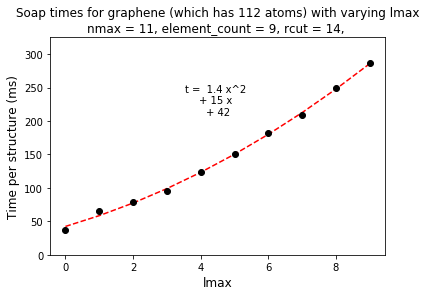

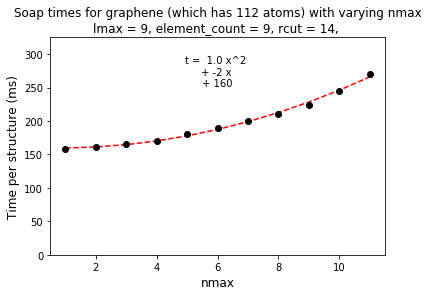

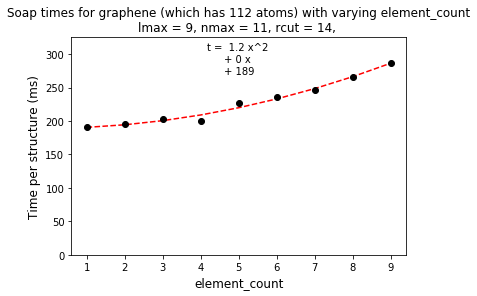

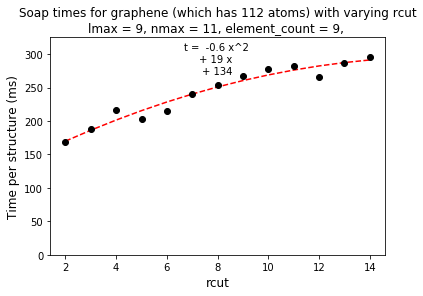

In [7]:
graphene = read("../data/ManyGraphenes.extxyz.gz",":")
graphene_profiler = dscribe_profiler(graphene, "graphene")
graphene_profiler.collect_all_times(initial_runs=0)
graphene_profiler.plot_all_times()

Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut


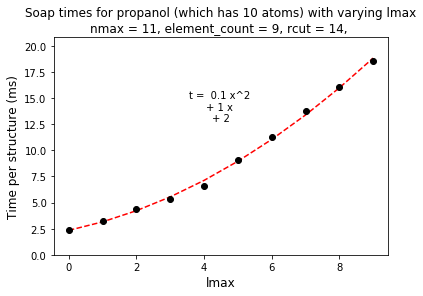

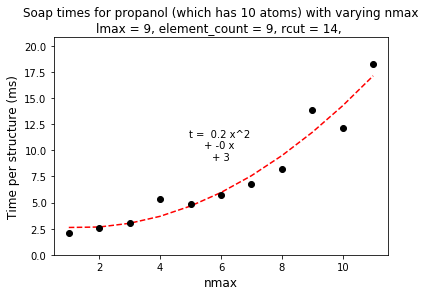

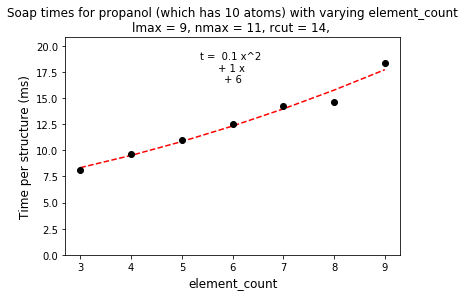

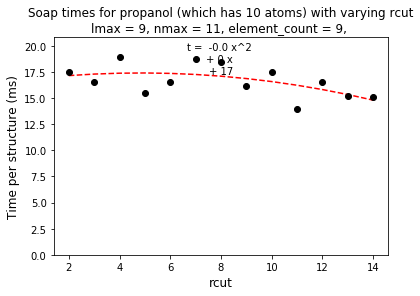

In [6]:
propanol = read("../data/distorted_propanol.extxyz.gz",":100")
propanol_profiler = dscribe_profiler(propanol, "propanol")
propanol_profiler.collect_all_times(initial_runs=0)
propanol_profiler.plot_all_times()

In [ ]:
diamond = bulk("C", 'diamond')
diamond_supercells = []
for i in range(1,15,2):
    diamond_supercells.append(make_supercell(diamond, np.identity(3)*i))
diamond_supercells_profiler = dscribe_profiler(diamond_supercells, "diamond_supercells")
diamond_supercells_profiler.vary_by_structure_mode()
diamond_supercells_profiler.collect_all_times(initial_runs=0)
diamond_supercells_profiler.plot_all_times()